# Reading Data

`mjolnir/quadcopter-sensors-ins`

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [229]:
from matplotlib import pyplot as plt
from collections import namedtuple
from slurm import storage
from struct import Struct
import numpy as np
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)

In [91]:
def plot3(data, title=None, xlabel=None, ylabel=None):
    plt.plot(data[:,0], label="x")
    plt.plot(data[:,1], label="y")
    plt.plot(data[:,2], label="z")
    plt.grid(True)
    plt.legend()
    if title: plt.title(title)
    if xlabel: plt.ylabel(xlabel)
    if ylabel: plt.ylabel(ylabel)

# Data Collection

In [148]:
SensorData = namedtuple("SensorData","header size unpack name")

BMP390 = SensorData(0xB2, 4*2, Struct('<2f').unpack, "pt") # pres,temp
SOXLIS = SensorData(0xF1, 4*9+4, Struct('<10f').unpack, "imu") # a,g,m,temp
TimeStamp = Struct('<L') # milliseconds

sensors = {}
sensors[SOXLIS.header] = SOXLIS
sensors[BMP390.header] = BMP390

In [226]:
def altitude(presure):
    seaLevel = 1013.25
    return 44330.0 * (1.0 - (presure / seaLevel)**0.1903)

In [202]:
def parse(data):
    t = None
    imu = None
    pt = None
    
    if data[:2] == b"\xff\xff":
        size = data[2]
            
        cnt = len(data[3:-6])
        i = 3

        while cnt > i:
            id = data[i]
            sen = sensors[id]
            i += 1
            d = tuple(sen.unpack(data[i:i+sen.size]))
            i += sen.size
            if sen.name == "imu":
                imu = d
            elif sen.name == "pt":
                pt = d
        t = TimeStamp.unpack(data[size-6:size-2])[0]
        # print(size,cnt,t, data[-6:-2], data[-2:])
    # else:
    #     print(f"** Wrong header: {data[:2]}")
    #     # raise Exception("Bad data?")
        
        
    return imu, pt, t #TimeStamp.unpack(data[-6:-2])

In [214]:
raw = storage.read("data.pickle")
print(f">> Read {len(raw)} data points")

>> Read 300 data points


In [215]:
imu = []
pt = []
ts = []
for r in raw:
    if len(r) > 0:
        ii, pp, tt = parse(r)
        if ii is None:
            continue
        else:
            imu.append(ii)
            pt.append(pp)
            ts.append(tt)
    
print(f"{len(imu)} good points found")

imu = np.array(imu)
pt = np.array(pt)
ts = np.array(ts)

300 good points found


In [216]:
np.diff(ts[:100])

array([ 6,  9,  7,  9,  6,  6, 10,  6,  6,  9,  6,  9,  6,  6,  9, 10,  6,
        6,  9,  9,  4,  9,  6,  9,  6,  7,  9,  6,  9,  6,  6,  9,  6,  9,
        7,  9,  9,  6,  7,  9,  6,  9,  6,  7,  9,  9,  6,  6,  6,  6,  9,
        6,  7,  9,  6,  9, 10,  6,  6,  6,  9,  7,  9,  6,  6,  9,  6,  6,
        9,  9,  7,  6,  9,  6,  6, 10,  9,  6,  6, 10,  6,  6,  9,  8,  7,
        6,  9,  9,  7,  6,  6,  9,  6, 10,  6,  9,  6, 10,  6])

In [221]:
accel = imu[:,:3]
gyro = imu[:,3:6]
mag = imu[:,6:9]
temp1 = imu[:,9]

temp2 = pt[:,0]
pres = pt[:,1]

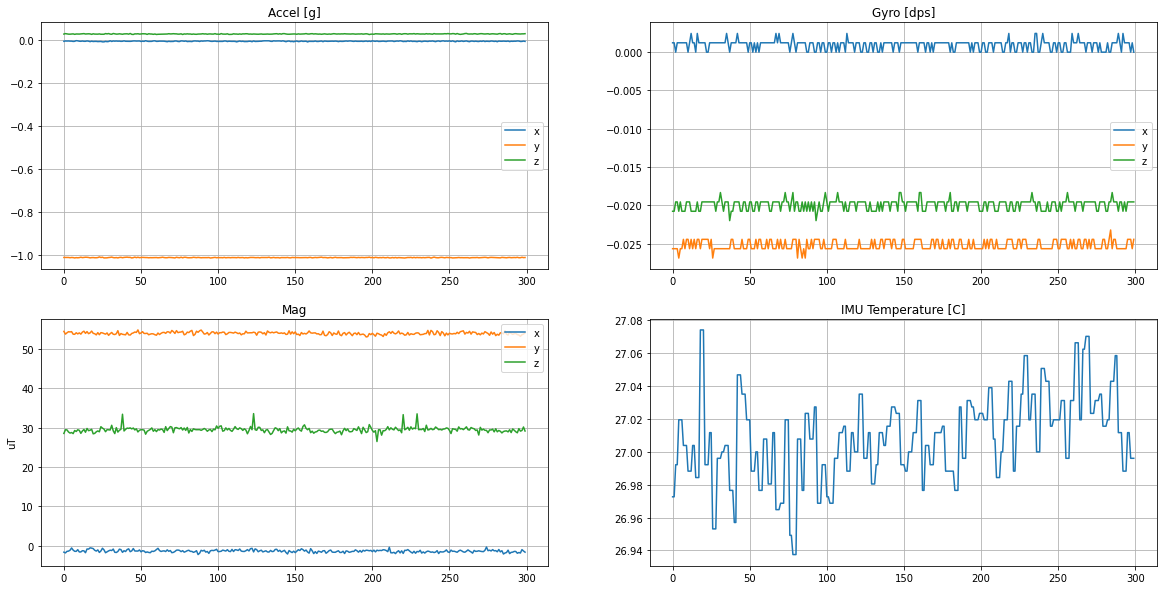

In [222]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plot3(accel, "Accel [g]")

plt.subplot(2,2,2)
plot3(gyro, "Gyro [dps]")

plt.subplot(2,2,3)
plot3(mag, "Mag", ylabel="uT")

plt.subplot(2,2,4)
plt.plot(temp1)
plt.grid(True)
plt.title("IMU Temperature [C]");

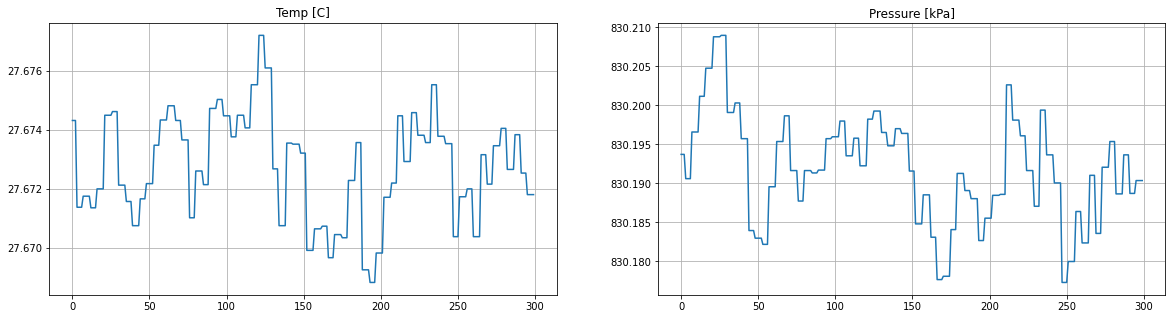

In [223]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1); plt.plot(temp2); plt.grid(True); plt.title("Temp [C]")
plt.subplot(1,2,2); plt.plot(pres); plt.grid(True); plt.title("Pressure [kPa]");

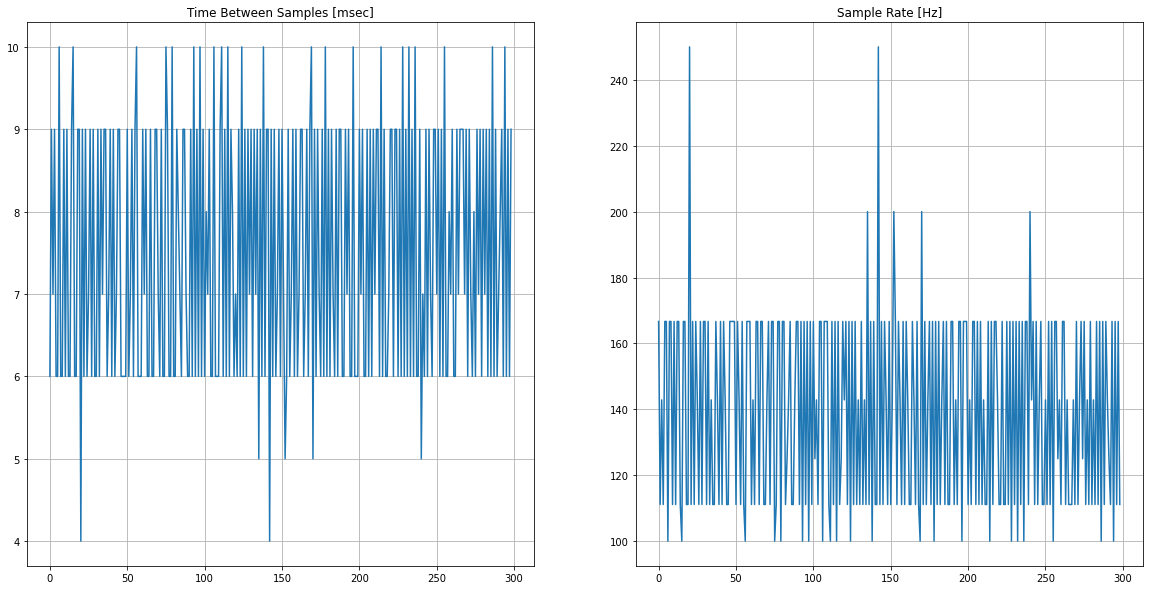

In [224]:
dd = np.diff(ts)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(dd)
plt.title("Time Between Samples [msec]")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(1/(dd*0.001))
plt.title("Sample Rate [Hz]")
plt.grid(True);

# Save

Now that the data is checked and appears to be good, save a copy of the parsed data.

In [61]:
sdata = {
    "accel": accel,
    "mag": mag,
    "gyro": gyro,
    "imutemp": temp,
    "temp": tp[:,0],
    "press": tp[:,1],
    "lidar": lidar,
    "ts": ts
}

# storage.write(f"parsed-data-{datetime.date.today().isoformat()}.pickle", sdata)

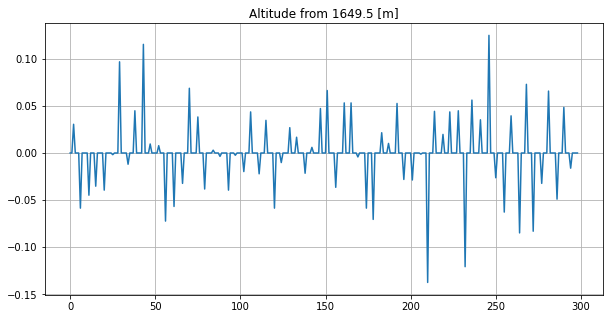

In [235]:
plt.figure(figsize=(10,5))
plt.plot(np.diff(altitude(pres)))
plt.grid(True)
plt.title(f"Altitude from {np.mean(altitude(pres)):.1f} [m]");